# Recurrent Neural Networks

### Practical Session

<br/> Student Arminas Bosas
<br/> email: arminas.bo9671@go.kauko.lt

## Contents

1. Data loading and pre-processing
2. Building the RNN
3. Train and deploy the RNN
4. Improving the RNN

## Challenge

<img src="https://www.aerotime.aero/aviation-blog/wp-content/uploads/2016/06/Boeing-Logo.svg.png"/>

Given a 10-year history of the Boeing Stock prices predict the stock values for the period of the recent most month that are not included in the historical data.

## Data loading and pre-processing

### Download the data-sets

The data-sets are two comma-separated values files (CSV) and contain a data table of 2537 records for training and a table of 23 records for testing.

They can be found at the [Yahoo.com website](https://finance.yahoo.com/quote/BA?p=BA&.tsrc=fin-srch)

Known alternative location: Github user [bosavykas](https://github.com/bosavykas/training-and-test-data) 

Open a terminal and use the wget command to get it of the selected location. Example:

```shell
wget https://raw.githubusercontent.com/bosavykas/training-and-test-data/main/training_data.csv

wget https://raw.githubusercontent.com/bosavykas/training-and-test-data/main/test_data.csv 
```


### Import libraries

We need 3 main libraries:

- [Numpy](http://www.numpy.org): it is the fundamental package for scientific computing with Python. It contains among other things a powerful N-dimensional array object that can be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined.
- [matplotlib](https://matplotlib.org):  it is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- [pandas](https://pandas.pydata.org): is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.

In [1]:
# library importation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

Dataset description: the open high, low and close values of the Boeing Stock from 2009 to 2019.


In [2]:
# Dataset importation

# loading contents of the file for July 1st 2009 - July 31st 2019 
dataset_train = pd.read_csv('training_data.csv')

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-01,42.630001,42.950001,42.150002,42.230000,32.061939,6346700
1,2009-07-02,41.810001,41.810001,40.619999,40.830002,30.999023,7201500
2,2009-07-06,40.380001,40.759998,39.919998,40.560001,30.794052,7132800
3,2009-07-07,40.500000,40.689999,38.939999,39.040001,29.640028,7701600
4,2009-07-08,39.119999,39.830002,38.919998,39.549999,30.027231,8800400


In [4]:
# Creating a subtable of related openings
# The .values option causes this vector to form a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [5]:
training_set

array([[ 42.630001],
       [ 41.810001],
       [ 40.380001],
       ...,
       [346.200012],
       [344.98999 ],
       [339.839996]])

Numpy arrays do not support the view() and head() methods. [More on accessing the numpy data](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html)


<img src="https://www.part.lt/img/33d457ecbc861af3ae2f7cf0da2e93ef530.PNG"/>

### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

Feature scaling is essential as discussed if the Features lecture and needs to be applied to both the training and test sets.

It is computed using the ScikitLearn library [MinMaxScaler()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) which transforms the selected feature by scaling it to a given range. If more than one, this estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [6]:
# Scaling the feature

# importing the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Creating a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [8]:
# Creating a certain training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [9]:
training_set_scaled

array([[0.00862641],
       [0.00661113],
       [0.00309666],
       ...,
       [0.7547003 ],
       [0.75172647],
       [0.7390695 ]])

### Splitting the training set to dependent and independent variables

<img src="https://drive.google.com/uc?id=1bckuLGZCeLUzNA-xJCGOODzC-4n2U-If"/>

In [10]:
# Creating a data structure with 90 timesteps and 1 output

# The 90 stock prices in the last 3 months before today
X_train = [] 

In [11]:
training_set_scaled.shape

(2537, 1)

In [12]:
# Today's stock price
y_train = [] 

In [13]:
# Starting from day 90, then going back 90 days 
for i in range(90, 2537): 
    # Number 0 defines column ID, which is the only column in this case    
    # Putting the last 90 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train

array([[0.00862641, 0.00661113, 0.00309666, ..., 0.02224188, 0.02251223,
        0.02302834],
       [0.00661113, 0.00309666, 0.00339158, ..., 0.02251223, 0.02302834,
        0.02602669],
       [0.00309666, 0.00339158, 0.        , ..., 0.02302834, 0.02602669,
        0.02676399],
       ...,
       [0.81599451, 0.8247438 , 0.82312173, ..., 0.82368694, 0.81388088,
        0.77922777],
       [0.8247438 , 0.82312173, 0.81021898, ..., 0.81388088, 0.77922777,
        0.7547003 ],
       [0.82312173, 0.81021898, 0.8009044 , ..., 0.77922777, 0.7547003 ,
        0.75172647]])

### Reshaping the Matrix

We need to add a new matrix dimension to accommodate the indicator (predictor). 

NumPy matrices are tensors (3D) and essentially we need to specify that our matrix consists of **90 days** (dimension x) times **total days in data set** (dimension y) times **1 value per matrix cell (scalar)** (dimension z)

<img src="https://cdn.pixabay.com/photo/2015/03/22/17/34/cubic-684961_1280.jpg" width="500" align="left"/>

If we were to add the stock value of somebody else together with the the past 90 days of Boeing, we need to change the length of the 3 dimension to  2.  RNN training tables are 3D!!! Read: [Reshaping NumPy Array | Numpy Array Reshape Examples](https://backtobazics.com/python/python-reshaping-numpy-array-examples/)

In [16]:
# Reformating the data matrix, we retain the 2 original dimensions and adding a third one with the depth of 1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

### RNN initialization

- Import the sequential model from the Keras API;
- Import the Dense layer template from the Keras API;
- Import the LSTM model from the Keras API
- Create an instance of the sequential model called regressor because we want to predict a continuous value

In [17]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
# Initialising the RNN as an arrangement of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [19]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [20]:
# The argument is the dropout rate to ignore in the layers (20%) 
# For example 100 units * 20% = 20 units will be dropped each time
regressor.add(Dropout(0.2))


### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.


In [21]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [22]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [23]:
# Adding a fourth LSTM layer and some Dropout regularisation
# I removed the return_sequences message, because we no longer return an arrangement, but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [24]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [25]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

### Fit the RNN to the Training set

We now want to train our RNN using the data in our **Training Set X** and **predictors in y** (ground truth in this case). Parameters that can be specified are the:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights


In [26]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
77/77 [==============================] - 11s 144ms/step - loss: 0.0088
Epoch 2/100
77/77 [==============================] - 11s 139ms/step - loss: 0.0023
Epoch 3/100
77/77 [==============================] - 11s 142ms/step - loss: 0.0020
Epoch 4/100
77/77 [==============================] - 11s 140ms/step - loss: 0.0018
Epoch 5/100
77/77 [==============================] - 11s 143ms/step - loss: 0.0017
Epoch 6/100
77/77 [==============================] - 12s 155ms/step - loss: 0.0016
Epoch 7/100
77/77 [==============================] - 11s 145ms/step - loss: 0.0017
Epoch 8/100
77/77 [==============================] - 10s 136ms/step - loss: 0.0017
Epoch 9/100
77/77 [==============================] - 10s 136ms/step - loss: 0.0016
Epoch 10/100
77/77 [==============================] - 11s 137ms/step - loss: 0.0014
Epoch 11/100
77/77 [==============================] - 11s 136ms/step - loss: 0.0013
Epoch 12/100
77/77 [==============================] - 10s 135ms/step - loss: 0.0018
E

### Computing Predictions

Create a data-frame by importing the Boeing Stock Price Test set for August of 2019 using pandas and make it a numpy array.

There are 21 financial days in one month, weekends are excluded!


In [27]:
# Getting the real stock price for August 1st 2019 - August 31st 2019

dataset_test = pd.read_csv('test_data.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-01,341.910004,344.290009,333.000000,334.290009,328.335938,6465300
1,2019-08-02,334.559998,340.540009,332.320007,339.559998,333.512085,4675400
2,2019-08-05,332.459991,333.369995,326.959991,331.059998,325.163452,5876100
3,2019-08-06,333.989990,335.700012,329.140015,332.450012,326.528748,3653300
4,2019-08-07,328.600006,333.649994,324.570007,331.380005,325.477783,4187600
5,2019-08-08,331.299988,336.429993,328.859985,336.350006,332.420715,3673000
6,2019-08-09,334.059998,339.079987,333.170013,337.549988,333.606689,3102900
7,2019-08-12,333.679993,336.010010,331.369995,332.940002,329.050537,2542500
8,2019-08-13,331.820007,337.399994,330.500000,332.859985,328.971466,3689700
9,2019-08-14,328.350006,329.540009,320.410004,320.420013,316.676788,5110400


In [28]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

22

In [29]:
real_stock_price

array([[341.910004],
       [334.559998],
       [332.459991],
       [333.98999 ],
       [328.600006],
       [331.299988],
       [334.059998],
       [333.679993],
       [331.820007],
       [328.350006],
       [323.      ],
       [330.220001],
       [334.179993],
       [332.470001],
       [335.480011],
       [342.429993],
       [355.350006],
       [365.040009],
       [359.420013],
       [353.309998],
       [363.850006],
       [364.369995]])

To predict the stock price value for each day in August 2019, we need the values in the last 90 days.

To obtain this **history** we need to combine both the training and test sets in one.

If we were to use the training_set and test_set we would need to use the scaler  but that would change the actual test values.  Thus concatenate the original data frames!


In [30]:
# Getting the predicted stock price of the future

# Axis = 0 means concatenate the lines (for example: vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [31]:
dataset_total.size


2559

In [32]:
# The contrast in the length of the first two gives us the first day in July 2019, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [33]:
inputs.size

112

In [34]:
# I did not use iloc from panda so lets rearrange the numpy array for compatibility, for example: all the values from input lines to be stacked in one column. The -1 means that the numpy has no knowledge of how the values were stored in lines. The 1 means I want to them in one column

inputs = inputs.reshape(-1,1) 

# Applying the feature scaler
inputs = sc.transform(inputs)

1. For each price in Aug. 2019 we need the **immediate 90 values** before it. 
2. We have 22 prices in August;
3. We need a numpy 3D array of 90 prices (columns) times 22 days (rows) times 1 dependent variable 
4. We don’t need y_test. That is what we are trying to compute!


In [35]:
# Getting the predicted stock price of the future
X_test = []

In [36]:
# The first 90 from inputs are from training set, starting from 90 and getting the extra 22
for i in range(90, 112): 
    X_test.append(inputs[i-90:i, 0])


In [37]:
X_test = np.array(X_test)

In [38]:
# Creating a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [39]:
predicted_stock_price = regressor.predict(X_test)

In [40]:
# I need to inverse the scaling to get useful predicted stock price
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

22

### Result Visualization


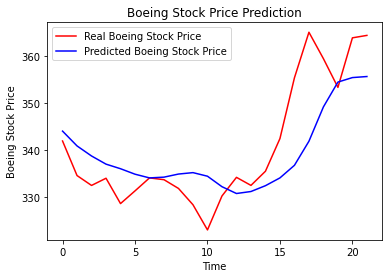

In [41]:
# Visualisation of the results by graph

plt.plot(real_stock_price, color = 'red', label = 'Real Boeing Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Boeing Stock Price')

plt.title('Boeing Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Boeing Stock Price')
plt.legend()

plt.show()

The blue line shows the trend of the stock for the month of August 2019. 

Some observations:
- The prediction lags behind the actual price curve because the model cannot react to fast non-linear changes. Spikes are examples of fast non-linear changes
- Model reacts pretty well to smooth changes

### Compute the RMSE

If we need to compute the RMSE for our Stock Price Prediction problem, we use the real stock price and predicted stock price as shown.

Then consider dividing this RMSE by the range of the Boeing Stock Price values of August 2019 to get a relative error, as opposed to an absolute error. 


In [42]:
# Importing the libraries
import math
from sklearn.metrics import mean_squared_error

In [43]:
rmse = math.sqrt( mean_squared_error( real_stock_price[0:30,:], predicted_stock_price))
rmse

8.4791523207726

## Improving the RNN

The new data need to be placed in the same order/format  as in the case of the training/test sets.

1. Getting more training data: we trained our model on the past 10 years of the  Boeing Stock Price.

2. Increasing the number of time steps: the model remembered the stock price from the 90 previous financial days to predict the stock price of the next day. That’s because we chose a number of 90 time steps.

3. Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Boeing, you could add this other stock price as a new indicator in the training data.

4. Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

5. Adding more neurons in the LSTM layers: we highlighted the fact that we needed a high number of neurons in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurons in each of our 4 LSTM layers. You could try an architecture with even more neurons in each of the 4 (or more) LSTM layers.

### Fine tuning the RNN

Parameter Tuning on the RNN model: we are dealing with a Regression problem because we predict a continuous outcome.

**Tip**: replace: scoring = 'accuracy' by scoring = 'neg_mean_squared_error' in the GridSearchCV class parameters as we did in the ANN case.